In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix,hstack,vstack
from scipy.sparse.linalg import svds
import io
import matplotlib.pyplot as plt
import seaborn as sn
import datetime

In [2]:
def Reconstruct_table(table):
    table=csr_matrix(table)
    
    #PCA_Dimention_Reduction
    u,s,vt=svds(table, k=300)
    mean_value=table.mean()
    table_mean=table.toarray()-mean_value
    d_table=np.dot(table_mean,np.transpose(vt))
    return csr_matrix(d_table)

In [3]:
def Reconstruct_labels(labels):
    # reconstruct the labels, make them into a understandable form
    rows=labels.shape[0]
    # find all the 30 labels
    all_labels=sorted((set(labels[1])))
    pre_labels = np.zeros(shape=(rows,30))
    i=0
    for word in all_labels:
        index=np.array(labels.index[labels[1].str.strip()==word])
        pre_labels[index,i]=1
        i=i+1
    pre_labels=csr_matrix(pre_labels)
    return pre_labels , all_labels

In [4]:
def score_performance(p,c):
    count=0
    l=c.shape[0]
    for i in range(0,l):
        if p[i]==c[i]:
            count=count+1
    return float (count)/float(l)

In [5]:
def generate_confusion_matrix(predict_labels,correct_labels,all_labels):
    size=predict_labels.shape[0]
    l=len(all_labels)
    confusion_matrix=np.zeros(shape=(l,l))
    for i in range(size):
        predict_index=all_labels.index(predict_labels[i])
        correct_index=all_labels.index(correct_labels[i])
        confusion_matrix[correct_index,predict_index]+=1
    return confusion_matrix

In [6]:
def plot_confusion_matrix(confusion_matrix,all_labels):
    df_cm = pd.DataFrame(confusion_matrix, index = all_labels,columns = all_labels)
    plt.figure(figsize = (15,9))
    sn.heatmap(df_cm, annot=True)
    

In [7]:
def analyze_confuson_matrix(confusion_matrix,all_labels):
    array1=np.zeros(shape=(1,5))
    for word in all_labels:
        index=all_labels.index(word)
        TP=float (confusion_matrix[index,index])
        FN =float( np.sum(confusion_matrix[index]) - TP)
        FP =float (np.sum(confusion_matrix[:, index]) - TP)
        TN = float (np.sum(confusion_matrix) - TP - FN - FP)
        precision=TP / (TP + FP)
        recall=TP / (TP + FN)
        F_measure=2*TP / (2*TP + FP + FN)
        accuracy=(TP + TN) / (TP + TN + FP + FN)
        support=(TP + FN)
        array2=np.zeros(shape=(1,5))
        array2[0,0]=precision
        array2[0,1]=recall
        array2[0,2]=F_measure
        array2[0,3]=accuracy
        array2[0,4]=support
        array1=np.vstack((array1,array2))
    ana_data=array1[1:31,:]
    df_data = pd.DataFrame(ana_data, columns = ['Precision', 'Recall', 'F-measure', 'Accuracy','Support'], index = all_labels)
    print(df_data)
    return df_data

In [8]:
class Multi_class_LR():
    def __init__(self,training_data,training_labels,test_data,all_labels,columns ):
        self.training_data=training_data
        self.training_labels=training_labels
        self.test_data=test_data
        self.all_labels=all_labels
        self.columns=columns
    
    def fit(self):
        self.weights_table=np.zeros(shape=(self.columns,30))
        for i in range(0,30):
            eta=0.5
            n_iter=20
            self.weights_table[:,i]=self.weight_calculate(self.training_data,self.training_labels[:,i],n_iter,eta)
        
        self.predict_table=self.logistic_predictions(csr_matrix(self.weights_table),self.test_data)
        self.predict_labels=self.my_predict()
        return self.predict_labels
    
    def weight_calculate(self,X,Y,n_iter,eta):
        N, D = X.shape
        weights = 5*np.random.random(D)[:, np.newaxis]
        for epoch in range(n_iter):
            dloss= self.logistic_loss_and_grad(csr_matrix(weights), X, Y)
            weights = weights  - dloss * eta 
        return np.transpose(weights)
    
    def logistic_loss_and_grad(self,weights, inputs, targets):
        #derivative of the loss function
        targets=targets.toarray()
        z = inputs.dot(weights).toarray()
        exp_z = np.exp(z)
        temp = -exp_z/(1 + exp_z) + targets
        m_t=csr_matrix(temp).multiply(inputs)
        sum_data=m_t.sum(axis=0)
        dloss = (-1)*np.array(sum_data)
        #calculating the loss is optional
        loss = (-1)*np.sum(-np.log(1.0 + exp_z) + targets*z)
        return np.transpose(dloss)
    def logistic_predictions(self,weights, inputs):
        z = inputs.dot(weights)
        z=z.toarray()
        return 1.0/(1.0 + np.exp(-z))
    _
    def my_predict(self):
        max_predict=list()
        l=self.predict_table.shape[0]
        for i in range(0,l):
            index_n=np.argmax(self.predict_table[i,:])
            max_predict.append(self.all_labels[index_n])
        return np.array(max_predict)
         

In [9]:
class Multi_class_Naive_Bayes():
    def __init__(self,training_data,training_labels,test_data,all_labels,columns ):
        self.training_data=training_data
        self.training_labels=training_labels
        self.test_data=test_data
        self.all_labels=all_labels
        self.columns=columns
    def fit(self):
        self.weights_table=np.zeros(shape=(self.columns,30))
        for i in range(0,30):
            one_class=self.training_labels[:,i]
            self.weights_table[:,i]=self.weight_calculate(one_class)
        
        self.predict_table=self.Bayes_predictions(self.test_data, csr_matrix(self.weights_table))
        self.predict_labels=self.my_predict()
        return self
    
    def weight_calculate(self,one_class):
        p_class=len(one_class.indices)/one_class.shape[0]
        filter_table=self.training_data.multiply(one_class)
        sum_all=filter_table.sum()
        sum_column=filter_table.sum(axis=0)
        
        # laplace smoothing and use logarithms due to very small floating point number probabilities
        a=0.1
        sum_column+=a*1
        sum_all+=a*self.columns
        weights=np.log(sum_column)-np.log(sum_all)+np.log(p_class)
        return weights
    def Bayes_predictions(self,inputs,weights):
        z = inputs.dot(weights)
        z=z.toarray()
        return z 
    
    def my_predict(self):
        max_predict=list()
        l=self.predict_table.shape[0]
        for i in range(0,l):
            index_n=np.argmax(self.predict_table[i,:])
            max_predict.append(self.all_labels[index_n])
        return np.array(max_predict)

In [10]:
def LR_test(table, labels):
    
    reconstruct_table=Reconstruct_table(table)
    pre_labels , all_labels=Reconstruct_labels(labels)
    rows,columns=reconstruct_table.shape
    training_ratio=0.5
    training_length=int(rows*training_ratio)
    test_length=rows-training_length
    
    training_data=reconstruct_table[0:training_length,:]
    test_data=reconstruct_table[training_length:rows,:]
    correct_labels_training=np.array(labels[0:training_length])
    correct_labels_test=np.array(labels[training_length:rows])
    training_labels=pre_labels[0:training_length,:]
    
    LR_test=Multi_class_LR(training_data,training_labels,test_data,all_labels,columns)
    LR_test.fit()
    accuracy_test=score_performance(LR_test.predict_labels,correct_labels_test)
    
    LR_training=Multi_class_LR(training_data,training_labels,training_data,all_labels,columns)
    LR_training.fit()
    accuracy_training=score_performance(LR_training.predict_labels,correct_labels_training)
    
    plot_confusion_matrix(LR_test.predict_labels,correct_labels_test,all_labels)
    print(accuracy_test,accuracy_training)
    return accuracy_test,accuracy_training
    

In [11]:
def Bayes_test(table, labels):
    start_time = datetime.datetime.now()
    pre_labels , all_labels=Reconstruct_labels(labels)
    rows,columns=table.shape
    table=csr_matrix(table)
    training_ratio=0.9
    training_length=int(rows*training_ratio)
    test_length=rows-training_length
    
    training_data=table[0:training_length,:]
    test_data=table[training_length:rows,:]
    correct_labels_training=np.array(labels[0:training_length])
    correct_labels_test=np.array(labels[training_length:rows])
    training_labels=pre_labels[0:training_length,:]
    
    NB_test=Multi_class_Naive_Bayes(training_data,training_labels,test_data,all_labels,columns)
    NB_test.fit()
    accuracy_test=score_performance(NB_test.predict_labels,correct_labels_test)
    
    NB_training=Multi_class_Naive_Bayes(training_data,training_labels,training_data,all_labels,columns)
    NB_training.fit()
    accuracy_training=score_performance(NB_training.predict_labels,correct_labels_training)
    cm=generate_confusion_matrix(NB_test.predict_labels,correct_labels_test,all_labels)
    analyze_confuson_matrix(cm,all_labels)
    print(accuracy_test,accuracy_training)
    print('Running time is ',datetime.datetime.now() - start_time)
    return accuracy_test,accuracy_training
   

In [12]:
# Perform K fold validation, default is 10
def K_fold_validation_LR(table, labels):
    K=10
    reconstruct_table=Reconstruct_table(table)
    pre_labels , all_labels=Reconstruct_labels(labels)
    rows,columns=reconstruct_table.shape
    test_length=float(rows/K)
    cm=np.zeros(shape=(30,30))
    all_precision=np.zeros(shape=(K,1))
    
    for i in range(K):
        start=int(i*test_length)
        finish=int((i+1)*test_length)
        test_data=reconstruct_table[start:finish,:]
        training_data=vstack([reconstruct_table[0:start,:],reconstruct_table[finish:rows,:]])
        correct_labels=np.array(labels[start:finish])
        training_labels=vstack([pre_labels[0:start,:],pre_labels[finish:rows,:]])
        LR=Multi_class_LR(training_data,training_labels,test_data,all_labels,columns)
        LR.fit()
        temp_cm=generate_confusion_matrix(LR.predict_labels,correct_labels,all_labels)
        cm+=temp_cm
        all_precision[i,0]=score_performance(LR.predict_labels,correct_labels)
        print(i+1,all_precision[i,0])
    analyze_confuson_matrix(cm,all_labels)
    plot_confusion_matrix(cm,all_labels)
    average_precision=sum(all_precision)/K
    print('The average corrected prediction is: ',average_precision)
        
        

In [13]:
def K_fold_validation_NB(table, labels):
    start_time = datetime.datetime.now()
    K=10
    pre_labels , all_labels=Reconstruct_labels(labels)
    table=csr_matrix(table)
    rows,columns=table.shape
    test_length=float(rows/K)
    cm=np.zeros(shape=(30,30))
    all_precision=np.zeros(shape=(K,1))
    for i in range(K):
        start=int(i*test_length)
        finish=int((i+1)*test_length)
        test_data=table[start:finish,:]
        training_data=vstack([table[0:start,:],table[finish:rows,:]])
        correct_labels=np.array(labels[start:finish])
        training_labels=vstack([pre_labels[0:start,:],pre_labels[finish:rows,:]])
        NB=Multi_class_Naive_Bayes(training_data,training_labels,test_data,all_labels,columns)
        NB.fit()
        temp_cm=generate_confusion_matrix(NB.predict_labels,correct_labels,all_labels)
        cm+=temp_cm
        all_precision[i,0]=score_performance(NB.predict_labels,correct_labels)
        print(i+1,all_precision[i,0])
    analyze_confuson_matrix(cm,all_labels)
    
    average_precision=sum(all_precision)/K
    print('The average corrected prediction is: ',average_precision)
    plot_confusion_matrix(cm,all_labels)
    print('Running time is ',datetime.datetime.now() - start_time)

In [14]:
def test_labels_generate(table, test,labels):
    pre_labels , all_labels=Reconstruct_labels(labels)
    rows,columns=table.shape
    table=csr_matrix(table)
    test=csr_matrix(test)
    NB=Multi_class_Naive_Bayes(table,pre_labels,test,all_labels,columns)
    NB.fit()
    return NB.predict_labels

In [15]:
if __name__ == '__main__':
    #loading data
    table = pd.read_csv('training_data.csv',delimiter=',',header=None,index_col=0).astype(np.float32).sort_index()
    labels = pd.read_csv('training_labels.csv',delimiter=',',header=None,index_col=0).sort_index()
    df_test = pd.read_csv('test_data.csv',delimiter=',',header=None,index_col=0).astype(np.float32)
    labels=labels.reset_index(drop=True)
    table=table.reset_index(drop=True)
    
  

The number of non-zero ti-idf value is:  1322042
0.07413562220413572


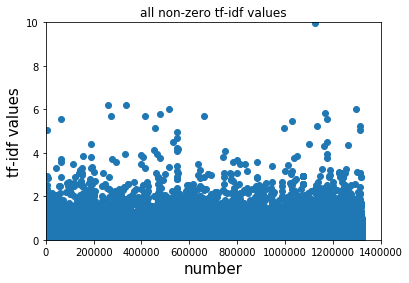

In [16]:
# inspect raw data
raw_data=csr_matrix(table)
non_zero_data=raw_data.data
non_zero_number=len(non_zero_data)

print('The number of non-zero ti-idf value is: ',non_zero_number)

x=np.arange(non_zero_number)
print(np.sum(non_zero_data)/non_zero_number)
plt.title( 'all non-zero tf-idf values')  
plt.axis([0,1.4e6,0,10])
plt.ylabel('tf-idf values',fontsize=15)
plt.xlabel('number',fontsize=15)
plt.scatter(x,non_zero_data)
plt.show()

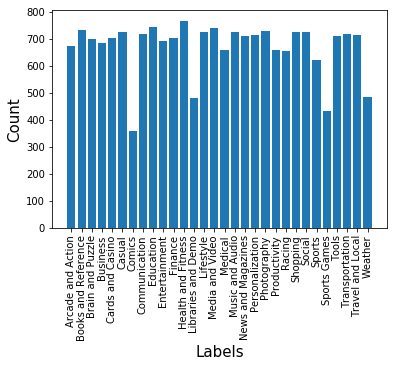

Arcade and Action :  671
Books and Reference :  730
Brain and Puzzle :  699
Business :  684
Cards and Casino :  703
Casual :  726
Comics :  359
Communication :  716
Education :  743
Entertainment :  692
Finance :  702
Health and Fitness :  766
Libraries and Demo :  479
Lifestyle :  726
Media and Video :  738
Medical :  657
Music and Audio :  725
News and Magazines :  710
Personalization :  715
Photography :  729
Productivity :  656
Racing :  654
Shopping :  723
Social :  726
Sports :  621
Sports Games :  432
Tools :  709
Transportation :  716
Travel and Local :  713
Weather :  484


In [17]:
# inspect labels
import seaborn as sns
all_labels=sorted((set(labels[1])))
count=list()

for word in all_labels:
    index=np.array(labels.index[labels[1].str.strip()==word])
    count.append(len(index))
count=np.array(count)   


plt.bar(all_labels, height= count)
plt.xlabel('Labels',fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.xticks(rotation=90)
plt.show()
for i in range(30):
    print(all_labels[i],': ',count[i])

1 0.6114427860696517
2 0.5940298507462687
3 0.5912481352560915
4 0.6139303482587065
5 0.583291894579811
6 0.6238805970149254
7 0.6059701492537314
8 0.6056688214818499
9 0.5626865671641791
10 0.5897563401292889
                     Precision    Recall  F-measure  Accuracy  Support
Arcade and Action     0.493491  0.621461   0.550132  0.966076    671.0
Books and Reference   0.560178  0.516438   0.537420  0.967718    730.0
Brain and Puzzle      0.617876  0.682403   0.648538  0.974284    699.0
Business              0.578467  0.463450   0.514610  0.970255    684.0
Cards and Casino      0.848980  0.887624   0.867872  0.990549    703.0
Casual                0.433052  0.494490   0.461736  0.958366    726.0
Comics                0.918919  0.094708   0.171717  0.983685    359.0
Communication         0.500629  0.555866   0.526803  0.964435    716.0
Education             0.546154  0.668910   0.601331  0.967220    743.0
Entertainment         0.376906  0.250000   0.300608  0.959958    692.0
Finance  

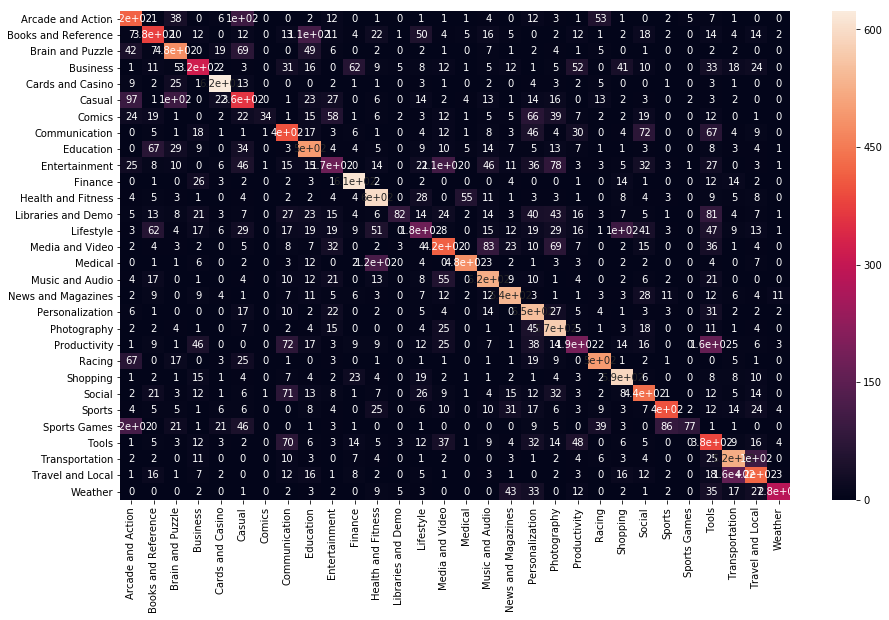

In [18]:
K_fold_validation_NB(table, labels)

1 0.5552238805970149
2 0.5258706467661691
3 0.5420188960716061
4 0.5726368159203981
5 0.5345599204375933
6 0.5890547263681593
7 0.5442786069651742
8 0.5743411238189955
9 0.5223880597014925
10 0.5589259075087022
                     Precision    Recall  F-measure  Accuracy  Support
Arcade and Action     0.552795  0.530551   0.541445  0.970006    671.0
Books and Reference   0.589951  0.498630   0.540460  0.969210    730.0
Brain and Puzzle      0.652038  0.595136   0.622289  0.974881    699.0
Business              0.445840  0.415205   0.429977  0.962545    684.0
Cards and Casino      0.848787  0.846373   0.847578  0.989355    703.0
Casual                0.484018  0.438017   0.459870  0.962843    726.0
Comics                0.658960  0.317549   0.428571  0.984879    359.0
Communication         0.501506  0.465084   0.482609  0.964485    716.0
Education             0.573620  0.503365   0.536201  0.967817    743.0
Entertainment         0.177570  0.384393   0.242922  0.917529    692.0
Finance 

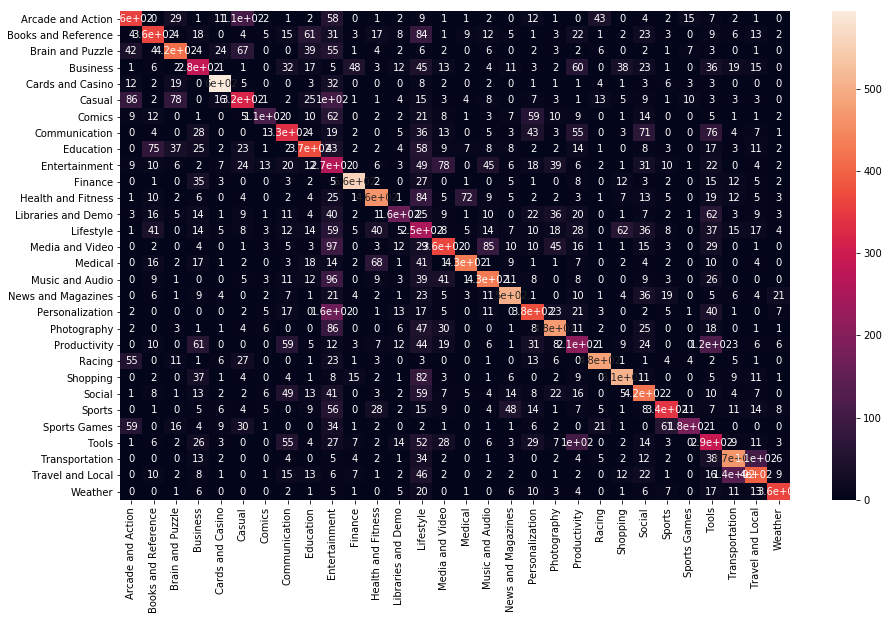

In [19]:
K_fold_validation_LR(table, labels)

In [20]:
# export output
test_predict_data=test_labels_generate(table,df_test,labels)
df_predict=pd.DataFrame(test_predict_data,index=df_test.index)
df_predict.to_csv('predict_labels.csv',header=False)

In [21]:
df_predict

,0
0,
dalmax.games.turnBasedGames.connect4,Brain and Puzzle
com.holfeld.japaneseplusfree,Travel and Local
com.mobileApp.controller,Productivity
com.aarontennyson.calorietracker,Health and Fitness
com.totaldevel.android.todocitas.ads,Books and Reference
com.google.android.voicesearch,Communication
fieldbird.yourself,Lifestyle
com.dmacattack.mpgConvert,Transportation
com.ds.tonsillectomy,Medical
